In [1]:
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
from scipy import ndimage

In [2]:
file_path = "series-00000/image-00000.dcm"

In [4]:
# Transforming to HU
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept
    return hu_image

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image<img_min] = img_min
    window_image[window_image>img_max] = img_max
    return window_image

In [7]:

# Removing Noise
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array

    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)

    label_count = np.bincount(labels.ravel().astype(int))
    label_count[0] = 0

    mask = labels == label_count.argmax()

    mask = morphology.dilation(mask, np.ones((1,1)))
    mask = ndimage.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3,3)))
    masked_image = mask * brain_image
    return masked_image



In [9]:
masked_img = remove_noise(file_path, display=True)

In [18]:
org = pydicom.read_file(file_path).pixel_array

(-0.5, 511.5, 511.5, -0.5)

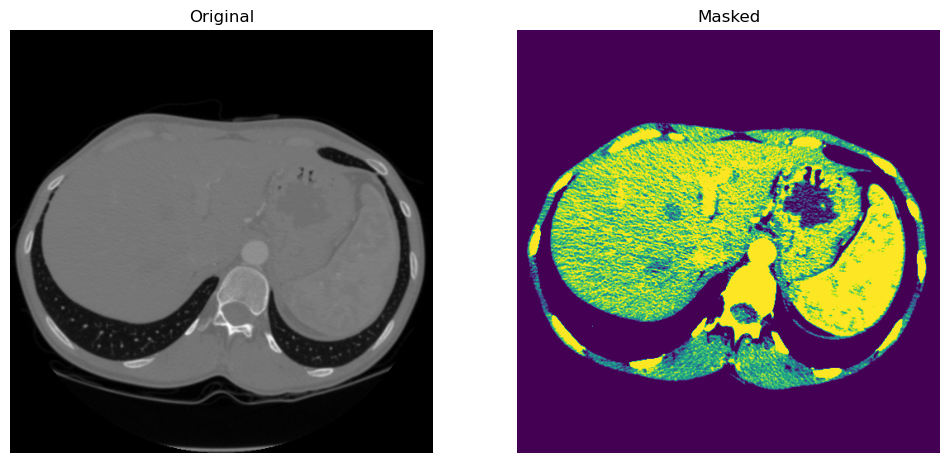

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8))
ax1.imshow(org, cmap='gray')
ax1.set_title('Original')
ax1.axis('off') 

ax2.imshow(masked_img)
ax2.set_title('Masked')
ax2.axis('off') 

